In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [478]:
dfb = pd.read_csv('/Users/genna/Dropbox/HackForLA/311/MyLA311_Service_Request_Data_2019.csv')

In [18]:
dfb.head()

SRNumber             CreatedDate             UpdatedDate ActionTaken  \
0  1-1262691971  12/31/2018 11:55:30 PM  01/02/2019 10:20:06 PM  SR Created   
1  1-1262694361  12/31/2018 11:53:51 PM  01/04/2019 02:37:07 PM  SR Created   
2  1-1262691941  12/31/2018 11:50:04 PM  01/15/2019 11:11:39 AM  SR Created   
3  1-1262691921  12/31/2018 11:43:07 PM  01/02/2019 11:10:40 AM  SR Created   
4  1-1262694331  12/31/2018 11:40:14 PM  01/02/2019 09:55:16 AM  SR Created   

  Owner       RequestType     Status RequestSource MobileOS Anonymous  ...  \
0   OCB  Graffiti Removal     Closed  Self Service      NaN         N  ...   
1   OCB  Graffiti Removal     Closed  Self Service      NaN         N  ...   
2   OCB  Graffiti Removal  Cancelled  Self Service      NaN         N  ...   
3   BOS       Bulky Items     Closed  Self Service      NaN         N  ...   
4   OCB  Graffiti Removal     Closed  Self Service      NaN         N  ...   

                          Location TBMPage TBMColumn TBMRow  \
0  (34.2473989385, -118.536249101)   500.0         J    5.0   
1   (34.086649927, -118.289288746)   594.0         A    6.0   
2   (33.9236735356, -118.29186988)   704.0         A    7.0   
3  (34.1191266964, -118.195252969)   595.0         C    1.0   
4   (34.107171697, -118.203784117)   595.0         B    3.0   

                     APC    CD            CDMember     NC  \
0       North Valley APC  12.0  Mitchell Englander  113.0   
1            Central APC  13.0     Mitch O'Farrell   34.0   
2  South Los Angeles APC  15.0        Joe Buscaino   90.0   
3   East Los Angeles APC  14.0         Jose Huizar   41.0   
4   East Los Angeles APC   1.0     Gilbert Cedillo   41.0   

                      NCName PolicePrecinct  
0            NORTHRIDGE WEST     DEVONSHIRE  
1          EAST HOLLYWOOD NC        RAMPART  
2    HARBOR GATEWAY NORTH NC      SOUTHEAST  
3  HISTORIC HIGHLAND PARK NC      NORTHEAST  
4  HISTORIC HIGHLAND PARK NC      NORTHEAST  

[5 rows x 33 columns]

In [5]:
dfb.profile_report(style={'full_width':True})

/anaconda3/envs/insight/lib/python3.7/site-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 0).')
  correlation_name=correlation_name, error=error


In [479]:
dfb['CreatedDate'] = pd.to_datetime(dfb['CreatedDate'])
dfb['ClosedDate'] = pd.to_datetime(dfb['ClosedDate'])
dfb['ServiceDate'] = pd.to_datetime(dfb['ServiceDate'])

Compute Service time (two ways to do this, not sure which is correct)

In [480]:
dfb['closed_created'] = dfb.ClosedDate-dfb.CreatedDate
dfb['service_created'] = dfb.ServiceDate-dfb.CreatedDate

In [21]:
dfb.closed_created.describe()

count                    1188932
mean      4 days 22:03:54.123607
std      17 days 22:57:08.377248
min         -1826 days +04:13:41
25%       0 days 17:05:22.750000
50%       1 days 20:21:11.500000
75%              4 days 06:42:53
max            617 days 08:07:27
Name: closed_created, dtype: object

NB: negative values are probably errors

In [26]:
dfb.closed_created.isna().sum()

5050

In [243]:
dfb.shape

(1193982, 35)

In [481]:
# drop NA and consider in terms of hours
dfb = dfb[~dfb.closed_created.isna()]

#df = dfb.closed_created.dropna().astype('timedelta64[D]')
#df = df[df.between(0,365)]

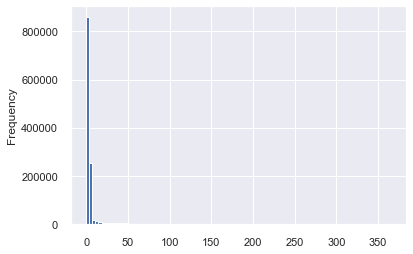

In [249]:
_ = dfb[dfb.closed_created.astype('timedelta64[D]').between(0,365)].closed_created.astype('timedelta64[D]').plot.hist(bins=100)

In [482]:
dfb['closed_createdD'] = dfb.closed_created / pd.Timedelta(days=1)

In [483]:
dfbD = dfb[(dfb.closed_createdD>(1.0/24.0)) & (dfb.Status=='Closed') & (dfb.NC==52)][['closed_createdD','RequestType']]

In [345]:
dfbD.closed_createdD.min()

0.041805555555555554

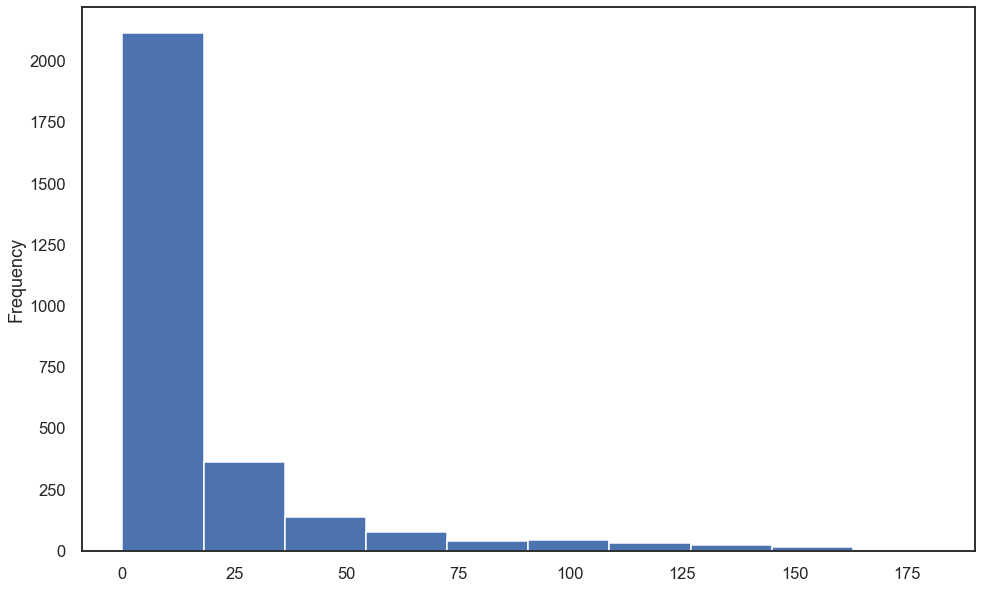

In [484]:
plt.figure(figsize=(16,10))
dfbD[(dfbD.RequestType=='Graffiti Removal')].closed_createdD.plot.hist(bins=10)
#ax = sns.violinplot(x=dfbD.RequestType,y=np.log(dfbD.closed_createdD))

In [427]:
dfbDavg = dfbD.groupby(['RequestType']).agg(['mean', 'std']).reset_index().sort_values(by=['RequestType'])

In [428]:
dfbDavg

RequestType closed_createdD           
                                          mean        std
0                  Bulky Items       13.170814  36.590056
1          Dead Animal Removal        0.591231   0.471469
2             Electronic Waste        4.538825   7.762416
3                     Feedback        1.624598   1.259467
4             Graffiti Removal       13.108404  30.100276
5          Homeless Encampment       60.428103  76.876013
6       Illegal Dumping Pickup       31.457687  57.376502
7   Metal/Household Appliances        4.723537   9.368471
8   Multiple Streetlight Issue       67.290034  85.527250
9                        Other        2.118686   5.934582
10    Single Streetlight Issue       44.847996  64.831699

In [440]:
dfbDavg['colorvals'] = sns.color_palette('colorblind',11)

In [441]:
dfbDavg

RequestType closed_createdD             \
                                          mean        std   
0                  Bulky Items       13.170814  36.590056   
1          Dead Animal Removal        0.591231   0.471469   
2             Electronic Waste        4.538825   7.762416   
3                     Feedback        1.624598   1.259467   
4             Graffiti Removal       13.108404  30.100276   
5          Homeless Encampment       60.428103  76.876013   
6       Illegal Dumping Pickup       31.457687  57.376502   
7   Metal/Household Appliances        4.723537   9.368471   
8   Multiple Streetlight Issue       67.290034  85.527250   
9                        Other        2.118686   5.934582   
10    Single Streetlight Issue       44.847996  64.831699   

                                            colorvals  
                                                       
0   (0.00392156862745098, 0.45098039215686275, 0.6...  
1   (0.8705882352941177, 0.5607843137254902, 0.019...  
2   (0.00784313725490196, 0.6196078431372549, 0.45...  
3       (0.8352941176470589, 0.3686274509803922, 0.0)  
4      (0.8, 0.47058823529411764, 0.7372549019607844)  
5   (0.792156862745098, 0.5686274509803921, 0.3803...  
6   (0.984313725490196, 0.6862745098039216, 0.8941...  
7   (0.5803921568627451, 0.5803921568627451, 0.580...  
8       (0.9254901960784314, 0.8823529411764706, 0.2)  
9   (0.33725490196078434, 0.7058823529411765, 0.91...  
10  (0.00392156862745098, 0.45098039215686275, 0.6...

In [442]:
dfbDavg = dfbDavg.sort_values(by=[('closed_createdD','mean')],ascending=False)

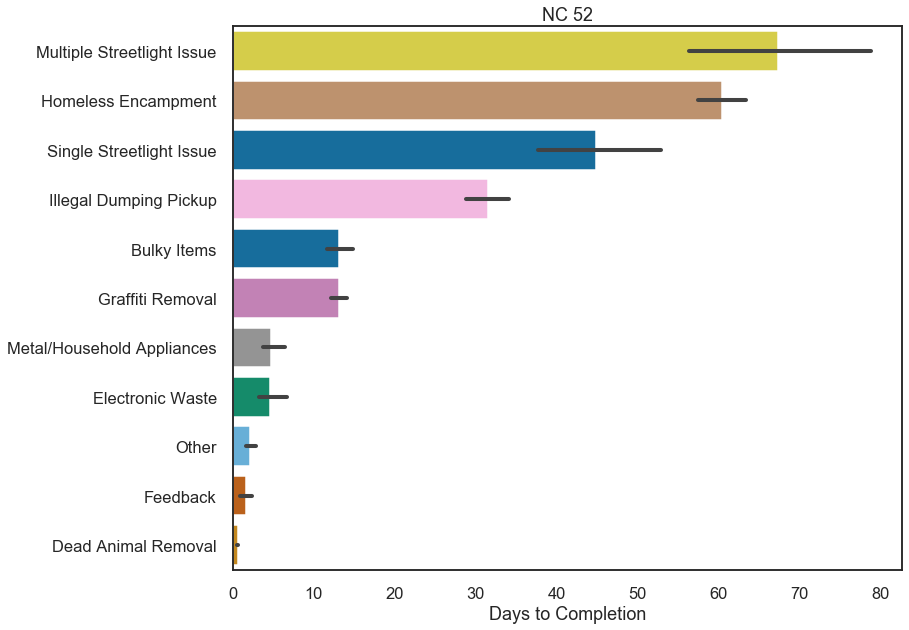

In [453]:
plt.figure(figsize=(12,10))
sns.set_style("white")
sns.set_context("talk")
ax = sns.barplot(y='RequestType',x='closed_createdD',data=dfbD, order=dfbDavg.RequestType, 
                 palette = list(dfbDavg.colorvals))
#ax = sns.barplot(y="RequestType", x=('closed_createdD','mean'), ci=('closed_createdD','std'), data=dfbDavg)
_ = ax.set(xlabel='Days to Completion',title='NC 52',ylabel='')

In [485]:
def time_to_complete(dfb,NC):
    dfbD = dfb[(dfb.closed_createdD>(1.0/24.0)) & (dfb.Status=='Closed') & (dfb.NC==NC)][['closed_createdD','RequestType']]
    dfbDavg = dfbD.groupby(['RequestType']).agg(['mean', 'std']).reset_index().sort_values(by=['RequestType'])
    dfbDavg['colorvals'] = sns.color_palette('colorblind',11)
    dfbDavg = dfbDavg.sort_values(by=[('closed_createdD','mean')],ascending=False)
    plt.figure(figsize=(12,10))
    sns.set_style("white")
    sns.set_context("talk")
    ax = sns.barplot(y='RequestType',x='closed_createdD',data=dfbD,order=dfbDavg.RequestType,palette = list(dfbDavg.colorvals))
    _ = ax.set(xlabel='Days to Completion',title='NC ' + str(NC),ylabel='')

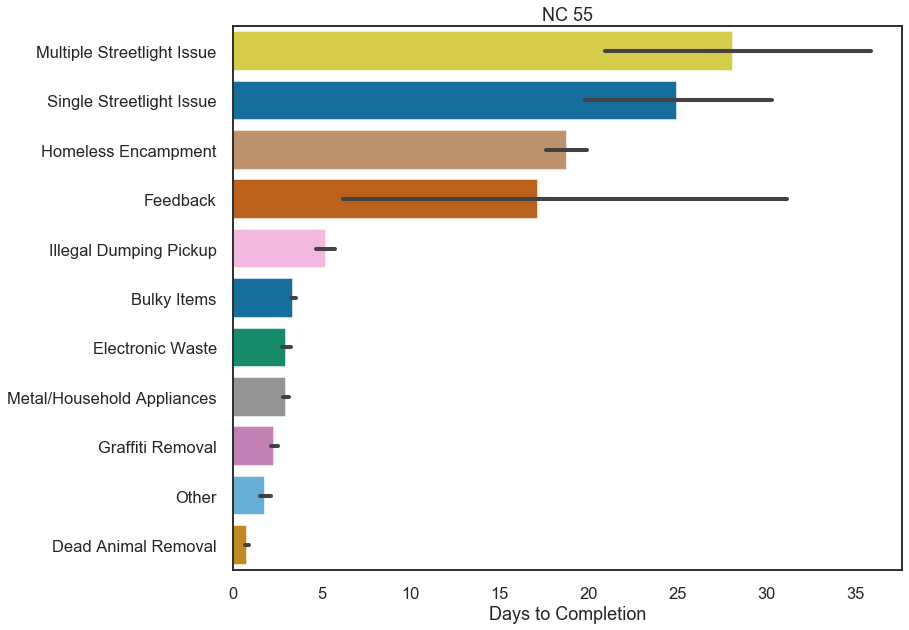

In [486]:
time_to_complete(dfb,55)

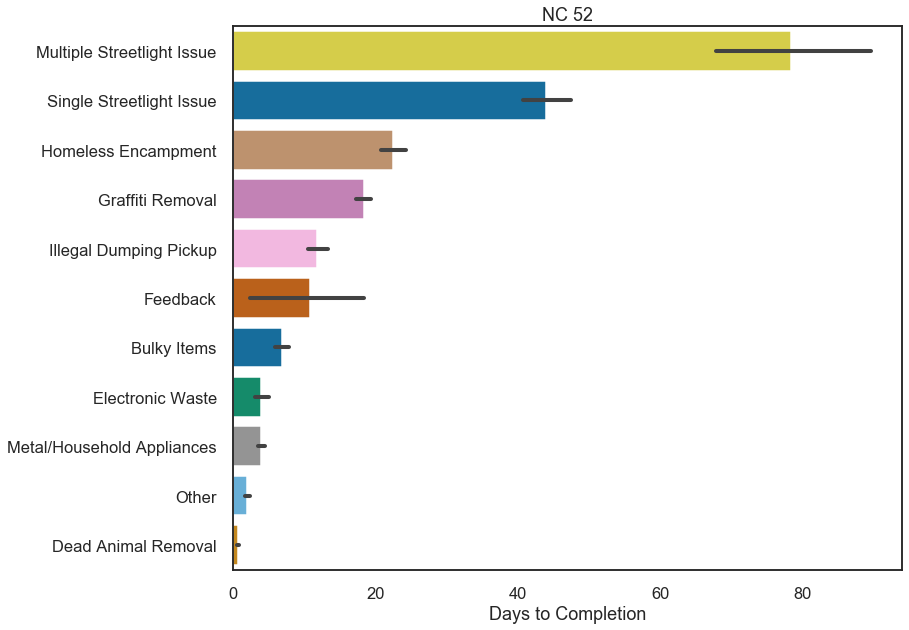

In [487]:
time_to_complete(dfb,52)

## Requests for a particular NC by request type

In [120]:
DTLA_Num = dfb.NC[dfb.NCName=='DOWNTOWN LOS ANGELES'].unique()[0]

In [222]:
nEvents = dfb[(dfb.NC==DTLA_Num) & (dfb.RequestType=='Graffiti Removal') & (dfb.Status=='Closed')].CreatedDate.astype('datetime64[D]').value_counts()

In [173]:
df_events = pd.DataFrame(nEvents).reset_index()

In [174]:
df_events.columns = ['date','nEvents']

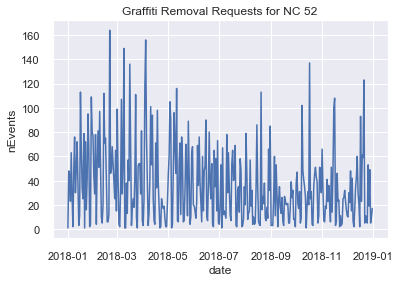

In [175]:
ax = sns.lineplot(x='date',y='nEvents',data=df_events)
_ = ax.set(title='Graffiti Removal Requests for NC 52')

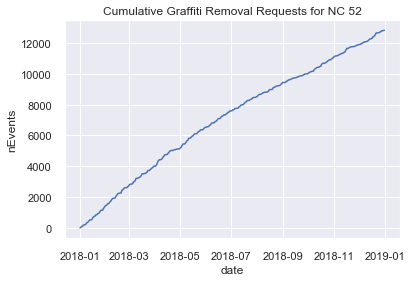

In [176]:
df_events = df_events.sort_values('date')
ax = sns.lineplot(x=df_events.date,y=df_events.nEvents.cumsum())
_ = ax.set(title='Cumulative Graffiti Removal Requests for NC 52')

In [223]:
df52 = dfb[(dfb.NC==DTLA_Num) & (dfb.Status=='Closed')]
df52['CRweek'] = df52.CreatedDate.dt.week
df52['CRmonth'] = df52.CreatedDate.dt.month

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [224]:
df52_week = pd.DataFrame(df52.groupby(['RequestType','CRweek']).SRNumber.count()).reset_index()
df52_month = pd.DataFrame(df52.groupby(['RequestType','CRmonth']).SRNumber.count()).reset_index()

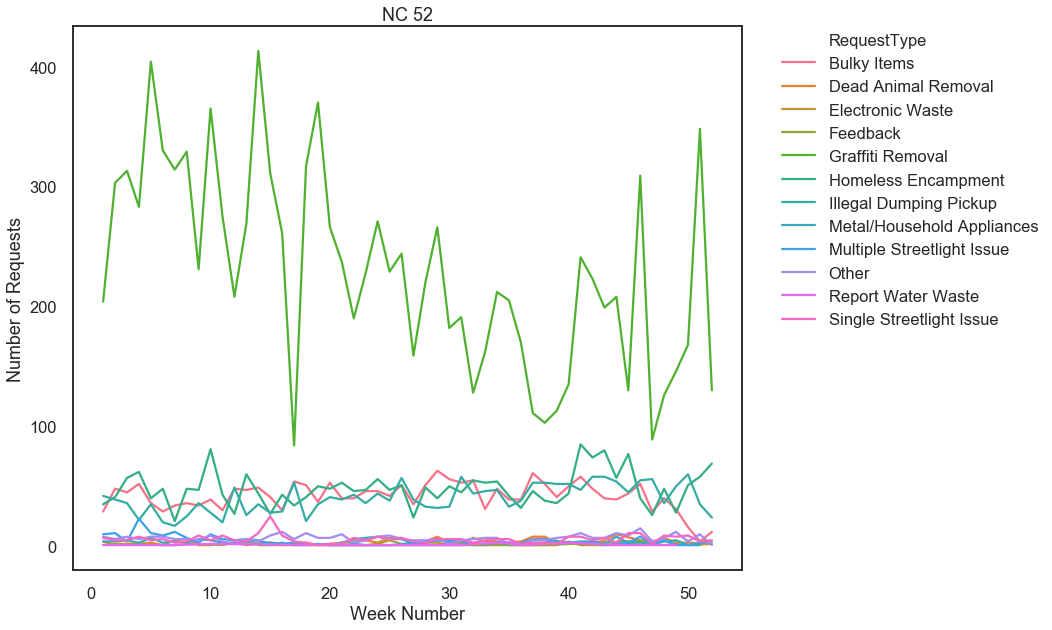

In [351]:
plt.figure(figsize=(12,10))
sns.set_style("white")
sns.set_context("talk")
ax = sns.lineplot(x='CRweek',y='SRNumber',hue='RequestType',data=df52_week)
ax.set(xlabel='Week Number',ylabel='Number of Requests',title='NC 52')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

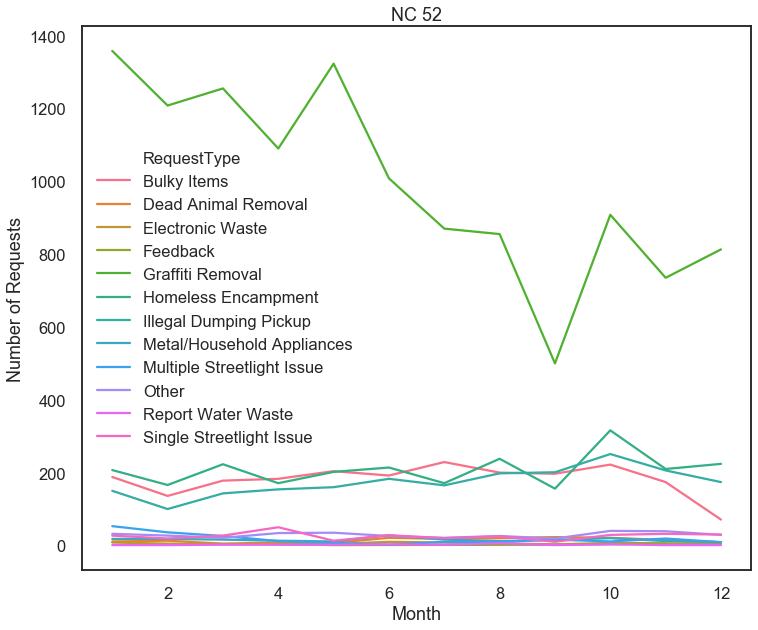

In [352]:
plt.figure(figsize=(12,10))
sns.set_style("white")
sns.set_context("talk")
ax = sns.lineplot(x='CRmonth',y='SRNumber',hue='RequestType',data=df52_month)
_ = ax.set(xlabel='Month',ylabel='Number of Requests', title='NC 52')

In [495]:
def requests_over_time(dfb,NC):
    df52 = dfb[(dfb.NC==NC) & (dfb.Status=='Closed')]
    df52['CRmonth'] = df52.CreatedDate.dt.month
    df52_month = pd.DataFrame(df52.groupby(['RequestType','CRmonth']).SRNumber.count()).reset_index()
    plt.figure(figsize=(12,10))
    sns.set_style("white")
    sns.set_context("talk")
    ax = sns.lineplot(x='CRmonth',y='SRNumber',hue='RequestType',data=df52_month)
    ax.set(xlabel='Month',ylabel='Number of Requests', title='NC ' + str(NC),ylim=(0,1500))
    _ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


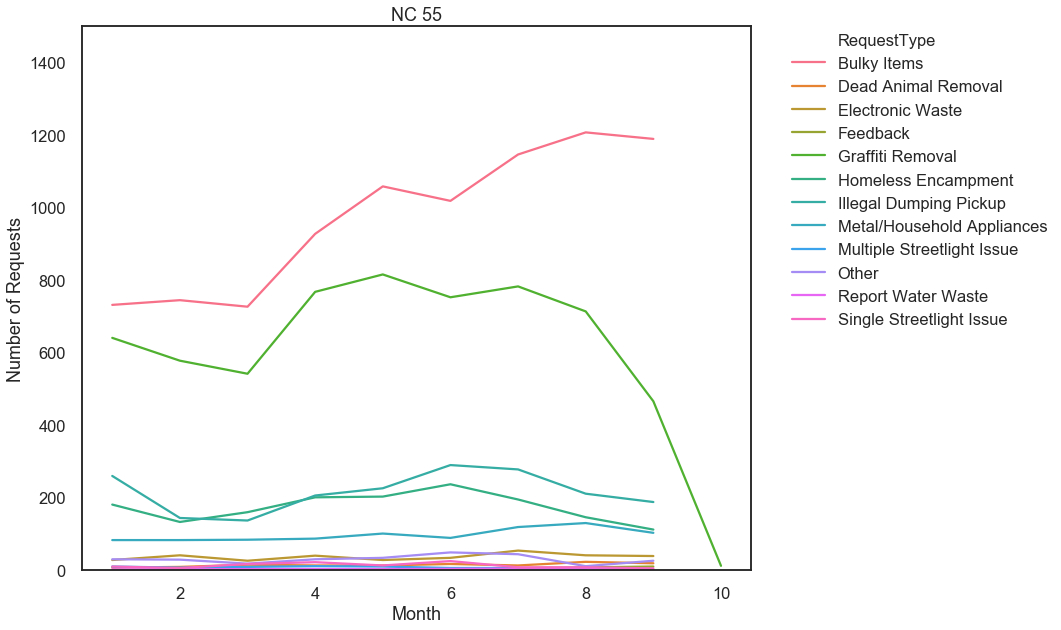

In [492]:
requests_over_time(dfb,55)

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


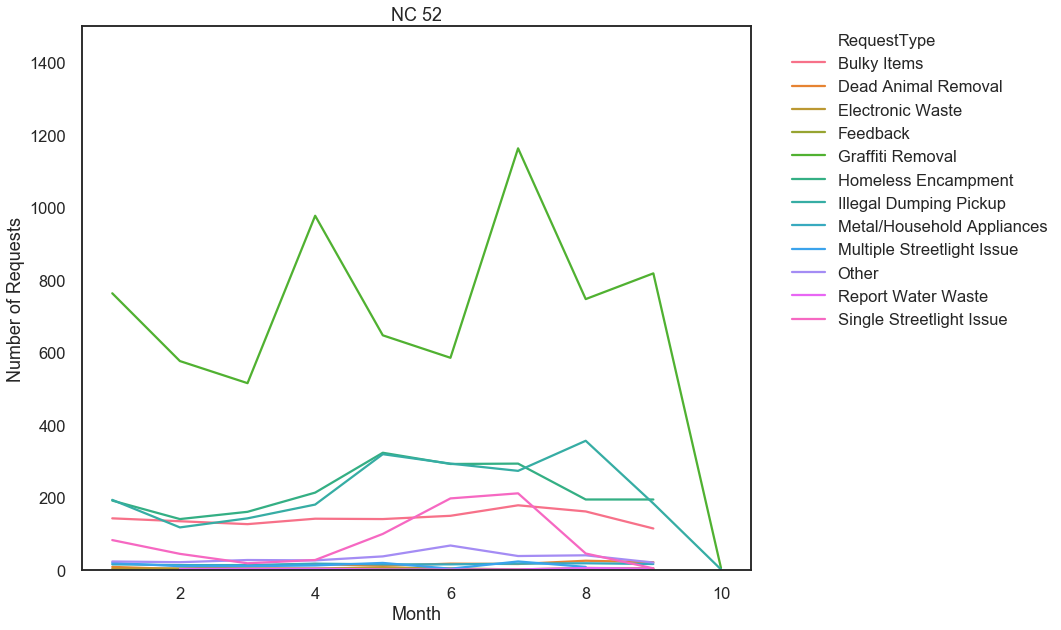

In [496]:
requests_over_time(dfb,52)